In [12]:
import random
import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm
import ast

df = pd.read_excel("Synthetic_Data.xlsx")

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm, norm
import random

# 1. Ownership Distribution with SBA 20% Rule
def generate_ownership_distribution():
    """Generates ownership percentages with 20% minimum for guarantors"""
    num_owners = random.choices([1, 2, 3, 4, 5], weights=[0.55, 0.35, 0.07, 0.02, 0.01])[0]
    
    # Generate shares ensuring each has at least 20%
    min_share = 20
    shares = []
    remaining = 100
    
    for _ in range(num_owners - 1):
        share = random.randint(min_share, remaining - (min_share * (num_owners - len(shares) - 1)))
        shares.append(share)
        remaining -= share
    
    shares.append(remaining)  # Last owner gets remaining
    shares.sort(reverse=True)
    return shares + [0] * (5 - num_owners)

# 2. Business Structure with PDF Weights
def generate_business_structure():
    """Business types with exact 100% weight distribution"""
    return random.choices(
        ["Sole Proprietorship", "LLC", "S Corporation (S-Corp)", "C Corporation (C-Corp)",
         "Partnership", "Franchise", "Nonprofit Organization", "Joint Venture"],
        weights=[0.25, 0.442, 0.25, 0.008, 0.02, 0.015, 0.005, 0.005]  # Sum=1.0
    )[0]

# 3. Credit Scores
def generate_fico_score():
    """FICO 8 scores (300-850) with proper distribution"""
    return int(truncnorm.rvs((300-670)/120, (850-670)/120, loc=670, scale=120))

def generate_business_score():
    """FICO SBSS scores (0-300) centered in 100-200 range"""
    return int(truncnorm.rvs((100-150)/30, (200-150)/30, loc=150, scale=30))

# 4. Financials with PDF Validation
def sample_dscr():
    """Generate DSCR values (0.4-2.0) with 1.25 as typical value"""
    return float(np.clip(np.random.normal(loc=1.25, scale=0.3), 0.4, 2.0).round(2))

def generate_financials():
    # 1. Generate revenue (whole thousands, 150K-5M range)
    revenue = int(round(np.random.randint(150000, 5000000), -3))  # Fixed syntax
    
    # 2. Generate DSCR first
    dscr = sample_dscr()
    
    # 3. Calculate MAX possible business debt
    max_possible_debt = int(revenue / dscr)
    
    # 4. Generate realistic business debt
    debt_min = 50000
    debt_max = min(max_possible_debt, 5000000)
    if debt_max < debt_min:  # Safety check
        debt_max = debt_min
    business_debt = np.random.randint(debt_min, debt_max + 1)
    
    # 5. Calculate NOI
    noi = int(dscr * business_debt)
    
    return {
        "Revenue": revenue,
        "DSCR": dscr,
        "NOI": noi,
        "Business Debt": business_debt
    }

# 5. Loan Amount
def generate_loan_amount():
    """Generates realistic SBA loan amounts with common preferences and edge cases"""
    # Define amount ranges with weighted probabilities
    amount_types = [
        # Type          # Range (in $1K)  # Weight  # Description
        ('microloan',   (25, 150),        0.1,     "SBA microloans <$150K"),
        ('express',     (150, 500),       0.25,     "Express loans $150K-$500K"),
        ('standard',    (500, 1000),      0.4,     "Common mid-size loans"),
        ('large',       (1000, 5000),     0.2,     "Large 7(a)/504 loans"),
        ('edge',        [25, 500, 5000],  0.05,     "Boundary amounts")
    ]
    
    # Select amount type based on weights
    type_choices, weights = zip(*[(t[0], t[2]) for t in amount_types])
    selected_type = random.choices(type_choices, weights=weights, k=1)[0]
    
    # Generate amount based on type
    for t in amount_types:
        if t[0] == selected_type:
            if t[0] == 'edge':
                base = random.choice(t[1])
            else:
                base = random.randint(t[1][0], t[1][1])
                
    # Round to nearest $5K for realism (common in business lending)
    loan_amount = (base * 1000) // 5000 * 5000
    
    # Ensure final amount stays within SBA limits
    return min(max(loan_amount, 25000), 5000000)

# 6. Main Data Generation Function
def generate_corrected_synthetic_data(n, seed=143):
    random.seed(seed)
    data = []
    city_list = ["New York, NY", "Los Angeles, CA", "Chicago, IL", "Houston, TX", "Phoenix, AZ",
                                    "Philadelphia, PA", "San Antonio, TX", "San Diego, CA", "Dallas, TX", "San Jose, CA",
                                    "Austin, TX", "Jacksonville, FL", "Fort Worth, TX", "Columbus, OH", "Charlotte, NC",
                                    "San Francisco, CA", "Indianapolis, IN", "Seattle, WA", "Denver, CO", "Washington, DC",
                                    "Boston, MA", "El Paso, TX", "Nashville, TN", "Detroit, MI", "Oklahoma City, OK",
                                    "Portland, OR", "Las Vegas, NV", "Memphis, TN", "Louisville, KY", "Baltimore, MD",
                                    "Milwaukee, WI", "Albuquerque, NM", "Tucson, AZ", "Fresno, CA", "Mesa, AZ",
                                    "Sacramento, CA", "Atlanta, GA", "Kansas City, MO", "Colorado Springs, CO", "Miami, FL",
                                    "Raleigh, NC", "Omaha, NE", "Long Beach, CA", "Virginia Beach, VA", "Oakland, CA",
                                    "Minneapolis, MN", "Tulsa, OK", "Tampa, FL", "Arlington, TX", "New Orleans, LA",
                                    "Wichita, KS", "Cleveland, OH", "Bakersfield, CA", "Aurora, CO", "Anaheim, CA",
                                    "Honolulu, HI", "Santa Ana, CA", "Riverside, CA", "Corpus Christi, TX", "Lexington, KY",
                                    "Stockton, CA", "Henderson, NV", "Saint Paul, MN", "St. Louis, MO", "Cincinnati, OH",
                                    "Pittsburgh, PA", "Greensboro, NC", "Anchorage, AK", "Plano, TX", "Lincoln, NE",
                                    "Orlando, FL", "Irvine, CA", "Newark, NJ", "Durham, NC", "Chula Vista, CA",
                                    "Toledo, OH", "Fort Wayne, IN", "St. Petersburg, FL", "Laredo, TX", "Jersey City, NJ",
                                    "Chandler, AZ", "Madison, WI", "Lubbock, TX", "Scottsdale, AZ", "Reno, NV",
                                    "Buffalo, NY", "Gilbert, AZ", "Glendale, AZ", "North Las Vegas, NV", "Winston-Salem, NC",
                                    "Chesapeake, VA", "Norfolk, VA", "Fremont, CA", "Garland, TX", "Irving, TX",
                                    "Hialeah, FL", "Richmond, VA", "Boise, ID", "Spokane, WA", "Baton Rouge, LA",
                                    "Tacoma, WA", "San Bernardino, CA", "Modesto, CA", "Fontana, CA", "Des Moines, IA",
                                    "Moreno Valley, CA", "Santa Clarita, CA", "Fayetteville, NC", "Birmingham, AL", "Oxnard, CA",
                                    "Rochester, NY", "Port St. Lucie, FL", "Grand Rapids, MI", "Huntsville, AL", "Salt Lake City, UT",
                                    "Frisco, TX", "Yonkers, NY", "Amarillo, TX", "Glendale, CA", "Huntington Beach, CA",
                                    "McKinney, TX", "Montgomery, AL", "Augusta, GA", "Aurora, IL", "Akron, OH",
                                    "Little Rock, AR", "Tempe, AZ", "Columbus, GA", "Overland Park, KS", "Grand Prairie, TX",
                                    "Tallahassee, FL", "Cape Coral, FL", "Mobile, AL", "Knoxville, TN", "Shreveport, LA",
                                    "Worcester, MA", "Ontario, CA", "Vancouver, WA", "Sioux Falls, SD", "Chattanooga, TN",
                                    "Brownsville, TX", "Fort Lauderdale, FL", "Providence, RI", "Newport News, VA", "Rancho Cucamonga, CA",
                                    "Santa Rosa, CA", "Peoria, AZ", "Oceanside, CA", "Elk Grove, CA", "Salem, OR",
                                    "Pembroke Pines, FL", "Eugene, OR", "Garden Grove, CA", "Cary, NC", "Fort Collins, CO",
                                    "Corona, CA", "Springfield, MO", "Jackson, MS", "Alexandria, VA", "Hayward, CA",
                                    "Clarksville, TN", "Lakewood, CO", "Lancaster, CA", "Salinas, CA", "Palmdale, CA",
                                    "Hollywood, FL", "Springfield, MA", "Macon, GA", "Kansas City, KS", "Sunnyvale, CA",
                                    "Pomona, CA", "Killeen, TX", "Escondido, CA", "Pasadena, TX", "Naperville, IL",
                                    "Bellevue, WA", "Joliet, IL", "Murfreesboro, TN", "Midland, TX", "Rockford, IL",
                                    "Paterson, NJ", "Savannah, GA", "Bridgeport, CT", "Torrance, CA", "McAllen, TX",
                                    "Syracuse, NY", "Surprise, AZ", "Denton, TX", "Roseville, CA", "Thornton, CO",
                                    "Miramar, FL", "Pasadena, CA", "Mesquite, TX", "Olathe, KS", "Dayton, OH",
                                    "Carrollton, TX", "Waco, TX", "Orange, CA", "Fullerton, CA", "Charleston, SC",
                                    "West Valley City, UT", "Visalia, CA", "Hampton, VA", "Gainesville, FL", "Warren, MI",
                                    "Coral Springs, FL", "Cedar Rapids, IA", "Round Rock, TX", "Sterling Heights, MI", "Kent, WA"]
    
    # Filtered NAICS codes (removed ineligible ones)
    eligible_naics = [311812, 312120, 323111, 325620, 332710, 333112, 337110, 339950, 423910, 424410,
                                441110, 441310, 442110, 443142, 444130, 445110, 445210, 445292, 446110, 448120,
                                448310, 451110, 451211, 453310, 453920, 481211, 484110, 484121, 488510, 491110,
                                511110, 512110, 515120, 517311, 518210, 519130,
                                523930, 524210, 531210, 532111, 532292, 541110, 541211, 541330,
                                541430, 541511, 541611, 541810, 541922, 561311, 561720, 561730, 561740, 561990,
                                611110, 611420, 611610, 621111, 621210, 621310, 621320, 621330, 621391, 621420,
                                621491, 621610, 621910, 623220, 624120, 624190, 624410, 711110, 711130, 711320,
                                711410, 711510, 712190, 713940, 721110, 722310, 722320, 722511, 722513,
                                722515, 811111, 811121, 811192, 811310, 812112, 812113, 812199, 812310, 812910,
                                813410, 813920, 921120, 921130, 921190, 922120, 922140, 922160,
                                923110, 924120, 925110, 926120, 927110, 928110, 928120, 928130, 929110, 929120,
                                931110, 931120, 931130, 931140, 931150, 931160, 931170, 931180, 931190, 931200,
                                931210, 931220, 931230, 931240, 931250, 931260, 931270, 931280, 931290, 931300,
                                931310, 931320, 931330, 931340, 931350, 931360, 931370, 931380, 931390, 931400,
                                931410, 931420, 931430, 931440, 931450, 931460, 931470, 931480, 931490, 931500,
                                931510, 931520, 931530, 931540, 931550]
    
    for i in range(n):
        # Generate loan amount
        loan_amount = generate_loan_amount()
        
        # Collateral logic with 5% exceptions
        collateral_availability = loan_amount > 25000
        if collateral_availability and random.random() < 0.05:
            collateral_availability = False

        # Generate business details
        applicant_id = i + 1
        business_structure = generate_business_structure()
        location = random.choice(city_list)
        naics = random.choice(eligible_naics)
        ownership_distribution = generate_ownership_distribution()

        # Generate financial history
        financials_2y = generate_financials()
        financials_1y = generate_financials()
        financials_latest = generate_financials()

        # Loan purposes with acquisition logic
        acquisition_request = random.choice([True, False])
        loan_purpose_flags = {
            "Business Acquisition or Buyout": acquisition_request,
            **{p: random.choice([True, False]) for p in [
                "Working Capital", "Business Expansion", "Equipment Purchase or Leasing",
                "Inventory Purchase", "Real Estate Acquisition or Improvement",
                "Refinancing Existing Debt", "Emergency Funds", "Franchise Financing",
                "Contract Financing", "Licensing or Permits", "Line of Credit Establishment"
            ]}
        }

        row = [
            applicant_id, business_structure, "US", location, naics, *ownership_distribution,
            generate_fico_score(), generate_business_score(),
            financials_2y["Revenue"], financials_1y["Revenue"], financials_latest["Revenue"],
            round((financials_latest["NOI"] / financials_latest["Revenue"]) * 100, 2),  # Net profit margin
            financials_2y["Business Debt"], financials_1y["Business Debt"], financials_latest["Business Debt"],
            financials_2y["NOI"], financials_1y["NOI"], financials_latest["NOI"],
            financials_2y["DSCR"], financials_1y["DSCR"], financials_latest["DSCR"],
            random.randint(0, 20),  # Industry experience
            random.randint(0, 20),  # Managerial experience
            random.randint(0, 15),  # Years in business
            collateral_availability, loan_amount,
            loan_amount < 500000,  # Fast approval
            business_structure != "Nonprofit Organization",
            acquisition_request,
            *loan_purpose_flags.values()
        ]

        data.append(row)

    columns = [
        "Applicant ID", "Business Structure", "Country", "Location", "NAICS",
        "Business Ownership (1)", "Business Ownership (2)", "Business Ownership (3)", 
        "Business Ownership (4)", "Business Ownership (5)", "Personal Credit Score", 
        "Business Credit Score", "Annual Revenue (2 years ago)", "Annual Revenue (1 year ago)", 
        "Annual Revenue (latest year)", "Net Profit Margin", "Business Debt (2 years ago)", 
        "Business Debt (1 year ago)", "Business Debt (latest year)", "NOI (2 years ago)", 
        "NOI (1 year ago)", "NOI (latest year)", "DSCR (2 years ago)", "DSCR (1 year ago)", 
        "DSCR (latest year)", "Industry Experience", "Managerial Experience", "Years in Business",
        "Collateral Availability", "Loan Amount", "Fast Approval", "For Profit", 
        "Acquisition Request", "Working Capital", "Business Expansion", 
        "Equipment Purchase or Leasing", "Inventory Purchase", 
        "Real Estate Acquisition or Improvement", "Business Acquisition or Buyout", 
        "Refinancing Existing Debt", "Emergency Funds", "Franchise Financing", 
        "Contract Financing", "Licensing or Permits", "Line of Credit Establishment"
    ]

    return pd.DataFrame(data, columns=columns)

In [3]:
# Generate the corrected dataset
df = generate_corrected_synthetic_data(100000)

In [4]:
df

,Applicant ID,Business Structure,Country,Location,NAICS,Business Ownership (1),Business Ownership (2),Business Ownership (3),Business Ownership (4),Business Ownership (5),...,Equipment Purchase or Leasing,Inventory Purchase,Real Estate Acquisition or Improvement,Business Acquisition or Buyout,Refinancing Existing Debt,Emergency Funds,Franchise Financing,Contract Financing,Licensing or Permits,Line of Credit Establishment
0,1,Sole Proprietorship,US,"Atlanta, GA",621391,100,0,0,0,0,...,True,True,True,False,False,True,False,False,False,True
1,2,Sole Proprietorship,US,"Corona, CA",722513,54,46,0,0,0,...,True,True,False,True,False,False,False,False,False,True
2,3,LLC,US,"Philadelphia, PA",532111,70,30,0,0,0,...,True,False,True,True,False,False,True,False,True,True
3,4,LLC,US,"New York, NY",448120,66,34,0,0,0,...,True,False,True,False,True,True,False,True,True,False
4,5,LLC,US,"Portland, OR",813410,100,0,0,0,0,...,False,True,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,S Corporation (S-Corp),US,"Savannah, GA",711110,100,0,0,0,0,...,False,False,True,False,False,False,False,False,True,True
99996,99997,S Corporation (S-Corp),US,"Sterling Heights, MI",931190,100,0,0,0,0,...,False,True,False,True,True,False,False,True,True,True
99997,99998,Sole Proprietorship,US,"Corpus Christi, TX",931180,100,0,0,0,0,...,False,True,True,True,True,True,True,True,True,True
99998,99999,S Corporation (S-Corp),US,"Toledo, OH",931120,100,0,0,0,0,...,True,True,False,False,False,False,False,True,False,False


In [5]:
import pandas as pd

class SBAEligibilityCriteria:
    def __init__(self):
        self.programs = {
            "7(a)": {
                "for_profit": True,
                "business_location": "US",
                "excluded_naics": [
                    522110, 522120, 522130, 522298, 713210, 813110, 531110, 531120, 813940
                ],
                "personal_credit_score": 680,
                "business_credit_score": 160,
                "dscr": 1.15,
                "loan_amount": 5000000,
                "experience_required": False,
                "fast_approval": False
            },
            "504": {
                "for_profit": True,
                "business_location": "US",
                "excluded_naics": [
                    522110, 522120, 522130, 522298, 713210, 813110, 531110, 531120, 813940
                ],
                "personal_credit_score": 680,
                "business_credit_score": None,
                "dscr": 1.15,
                "loan_amount": 5500000,
                "experience_required": False,
                "fast_approval": False
            },
            "8(a)": {
                "for_profit": False,
                "business_location": "US",
                "excluded_naics": [
                    522110, 522120, 522130, 522298, 713210, 813110, 531110, 531120, 813940
                ],
                "personal_credit_score": None,
                "business_credit_score": None,
                "dscr": None,
                "loan_amount": None,
                "experience_required": True,
                "fast_approval": False
            },
            "Express": {
                "for_profit": True,
                "business_location": "US",
                "excluded_naics": [
                    522110, 522120, 522130, 522298, 713210, 813110, 531110, 531120, 813940
                ],
                "personal_credit_score": 680,
                "business_credit_score": 160,
                "dscr": 1.15,
                "loan_amount": 500000,
                "experience_required": False,
                "fast_approval": True
            }
        }

        self.excluded_naics_categories = {
            "Speculative Businesses": None,
            "Lending Institutions": [522110, 522120, 522130, 522298, 523110, 523910],
            "Pyramid Sales Plans": None,
            "Gambling Businesses": [713210, 713290],
            "Illegal Activities": None,
            "Nonprofit Organizations": [813110, 813211, 813212, 813219, 813410],
            "Passive Businesses": [531110, 531120, 531190],
            "Religious Activities": [813110],
            "Political or Lobbying": [813940, 541820],
            "Life Insurance Companies": [524113, 524114],
            "Private Clubs": [713910, 713990],
            "Speculative Agriculture": [111930, 113110, 113210],
            "Businesses Abroad": None,
            "Immoral Activities": [711510, 812199]
        }

    def is_naics_excluded(self, naics_code):
        """Check if a NAICS code is excluded."""
        for program in self.programs.values():
            if naics_code in program.get("excluded_naics", []):
                return True
        return False

    def check_eligibility(self, business_profile, program):
        """Evaluate eligibility based on the provided business profile and program."""
        if program not in self.programs:
            return f"Program {program} not recognized."

        criteria = self.programs[program]

        # Check for profit/non-profit
        if business_profile["for_profit"] != criteria["for_profit"]:
            return "Ineligible: Not for profit."

        # Check for fast approval
        if business_profile["fast_approval"] != criteria["fast_approval"]:
            return "Ineligible: Not eligible for fast approval."

        # Check business location
        if business_profile["business_location"] != criteria["business_location"]:
            return "Ineligible: Business location is not in the U.S. or territories."

        # Check NAICS exclusions
        if self.is_naics_excluded(business_profile["naics_code"]):
            return f"Ineligible: NAICS code {business_profile['naics_code']} is excluded."

        # Check personal credit score
        if criteria["personal_credit_score"] and business_profile["personal_credit_score"] < criteria["personal_credit_score"]:
            return "Ineligible: Personal credit score is below the required threshold."

        # Check business credit score
        if criteria["business_credit_score"] and business_profile["business_credit_score"] < criteria["business_credit_score"]:
            return "Ineligible: Business credit score is below the required threshold."

        # Check DSCR
        if criteria["dscr"] and business_profile["dscr"] < criteria["dscr"]:
            return "Ineligible: DSCR is below the required threshold."

        # Check Loan amount
        if criteria["loan_amount"] and business_profile["loan_amount"] >= criteria["loan_amount"]:
            return "Ineligible: Loan amount greater than accepted value."

        # Check experience
        if criteria["experience_required"] and not business_profile["experience"]:
            return "Ineligible: Required experience is missing."

        return "Eligible"


# Define the columns to pass to the eligibility checker
columns_to_use = {
    "for_profit":"For Profit",
    "business_location": "Country",
    "naics_code": "NAICS",
    "personal_credit_score": "Personal Credit Score",
    "business_credit_score": "Business Credit Score",
    "dscr": "DSCR (latest year)",
    "experience": "Industry Experience",
    "fast_approval": "Fast Approval",
    "loan_amount": "Loan Amount"
}

# Map the dataframe columns to the required keys for the function
df_selected = df[list(columns_to_use.values())]
df_selected.rename(columns={v: k for k, v in columns_to_use.items()}, inplace=True)

# Initialize the eligibility checker
criteria_checker = SBAEligibilityCriteria()

# Function to evaluate all loan programs for a business
def evaluate_row(row):
    business_profile = row.to_dict()
    eligible_programs = []

    for program in criteria_checker.programs.keys():
        eligibility = criteria_checker.check_eligibility(business_profile, program)
        if eligibility == "Eligible":
            eligible_programs.append(program)

    return eligible_programs

# Add "Eligibility" column with the list of eligible programs
df["Eligibility"] = df_selected.apply(evaluate_row, axis=1)

/var/folders/bf/wnj5kb_x4ps5146xwy3y93bw0000gn/T/ipykernel_78995/1341590548.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={v: k for k, v in columns_to_use.items()}, inplace=True)


In [6]:
df['Eligibility'].value_counts()

Eligibility
[]             78994
[504]          11142
[7(a), 504]     6054
[Express]       3509
[8(a)]           301
Name: count, dtype: int64

In [7]:
df.to_csv("Synthetic_Loans_Data1.csv", index=False)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='Loan Amount'>

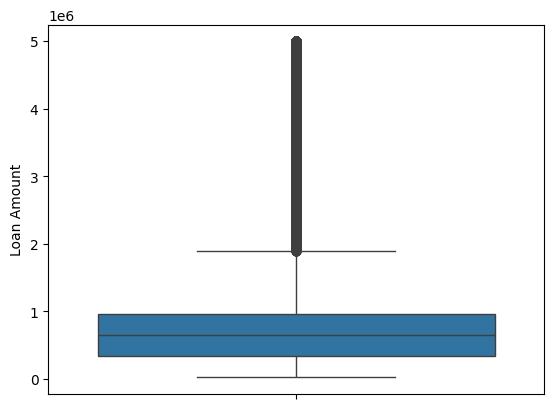

In [9]:
sns.boxplot(y=df['Loan Amount'])

In [10]:
val_df= generate_corrected_synthetic_data(10000, 400)
val_df.head()

,Applicant ID,Business Structure,Country,Location,NAICS,Business Ownership (1),Business Ownership (2),Business Ownership (3),Business Ownership (4),Business Ownership (5),...,Equipment Purchase or Leasing,Inventory Purchase,Real Estate Acquisition or Improvement,Business Acquisition or Buyout,Refinancing Existing Debt,Emergency Funds,Franchise Financing,Contract Financing,Licensing or Permits,Line of Credit Establishment
0,1,Sole Proprietorship,US,"Little Rock, AR",931170,100,0,0,0,0,...,False,False,True,False,True,True,True,True,False,False
1,2,Sole Proprietorship,US,"Indianapolis, IN",931520,76,24,0,0,0,...,True,True,True,True,True,False,True,False,False,False
2,3,S Corporation (S-Corp),US,"Spokane, WA",624410,76,24,0,0,0,...,False,False,False,True,False,True,False,True,True,True
3,4,S Corporation (S-Corp),US,"Albuquerque, NM",922160,61,39,0,0,0,...,False,False,True,True,False,False,False,True,True,True
4,5,LLC,US,"St. Louis, MO",621420,70,30,0,0,0,...,False,True,False,True,True,True,False,False,False,False


In [11]:
val_df.to_csv("Synthetic_Loans_Data_val.csv", index=False)